# 外れ値検知入門

外れ値とは他のデータから数値的に離れている観測値です。簡単に言えば**範囲外の値**のことです。外れ値のあるデータセットと無いデータセットで何が起こるか例を上げて確認してみましょう。

||外れ値無し|外れ値有り|
|---|---|---|
|Data|1, 2, 3, 3, 4, 5, 4|1, 2, 3, 3, 4, 5, **400**|
|Mean|3.142|**59.714**|
|Median|3|3|
|Standard Deviation|1.345|**150.057**|

このように外れ値を含むデータセットは、平均値と標準偏差が大きく異なります。

次のような例も考えてみましょう。

- 従業員 50 名の会社
- 45 人の月給：30 万円
- 5 人の月給：200 万円

この場合、従業員の平均月給は 47 万円となり現実とは乖離した結論になります。（従業員の大半は 47 万円以下しか支給されていない。）  
しかし、中央値を取ると、30 万円となり平均値よりも意味のある結論になります。  
このため、平均値よりも中央値のほうが適切な指標となります。

## 外れ値の原因

外れ値が発生する原因は様々考えられますが、一例として

- データ入力ミス：データの収集・記録・入力時等に発生するヒューマンエラー
- 測定ミス：使用した測定器の誤作動や故障していた場合に発生する
- 自然外れ値：外れ値が人為的なもの・機器のエラーによるものでない場合に発生する。現実のデータのほとんどはこのカテゴリに属する  

などが考えられます。  

## 外れ値検知の実装 
ここからは外れ値検知の実装を行います。  
本章では以下の 2 つについて触れます。  

1. Z-score method  
2. （補足）Robust Z-score  
3. ホテリング $T^{2}$ 法  


## Z-score method



$Z$ スコア法はいわゆる 3σ 法を流用した外れ値検知手法です。これは、データの平均から 3σ 内に含まれるデータは全体の分布の 99.7% が含まれるという理論からできており、この方法の外れ値検知でわかることは、平均値から何標準偏差分離れているかを知ることができます。 

![02](img/04/02.jpeg)  

$$
Z_{score} = \frac{X-{Mean}}{StandardDeviation}
$$

実装方法としてもある程度理解しやすく、あるデータの $Z$ スコアの絶対値が 3 $\sigma$ 以上であれば、そのデータは他の値とはかなり異なっている（外れ値）と見なします。  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

今回は取り組みやすいように、サンプルのデモデータを用いて実装します。  

In [2]:
# データの準備
np.random.seed(0)
x = np.random.normal(0, 1, 1000)
anomaly = np.array([-5, 5])
data = np.concatenate([x, anomaly], axis=0)

データの分布を確認します。  

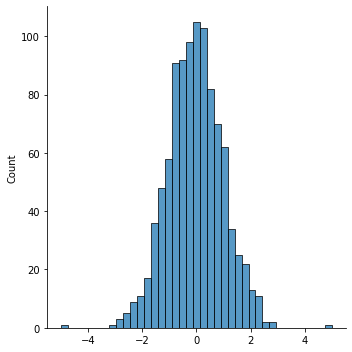

In [3]:
sns.displot(data)

散布図も確認しましょう。  

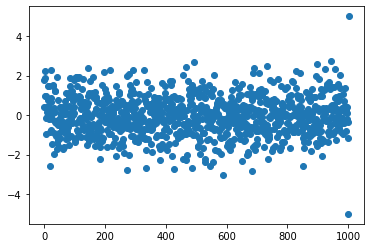

In [6]:
plt.scatter(range(len(data)), data)

いくつか全体から外れているデータが有ることがわかります。  

In [7]:
# 関数
def z_score_outlier(x):
    out = []
    out_idx = []
    mean = np.mean(x)
    std = np.std(x)
    for n, i  in enumerate(x):
        z = (i-mean) / std
        if np.abs(z) > 2:
            out.append(i)
            out_idx.append(n)
    return out, out_idx

In [8]:
out, out_idx = z_score_outlier(data)

In [9]:
np.min(out), np.max(out)

(-5.0, 5.0)

この出力からは、先程可視化した散布図の右上のデータと右下のデータが取得できていることがわかります。
散布図で色分けして可視化してみましょう。  

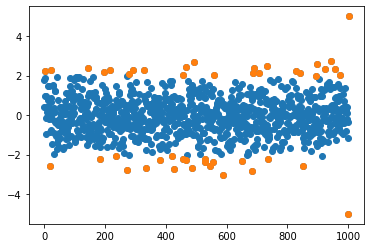

In [10]:
plt.scatter(range(len(data)), data)
plt.scatter(out_idx, data[out_idx]);

このようにいくつかのデータが外れ値検知されていることがわかります。個の結果からも、データの真ん中（縦軸の 0）より一定区間上下に離れている点が検出されており、これが 3σ を超えたものであることがわかります。  

## Robust Z-score  
先程実装したものによく似た手法として、Robust Z-score method があります。別名、Median absolute deviation 法とも呼ばれます。  

$Z$ スコア法と似ていますが、用いている中央の値が異なります。平均値と標準偏差は外れ値に大きく影響される特徴がありますが、その点を考慮し中央値と中央値からの絶対偏差を使用したものがこちらの手法です。数式が少し変わった程度であるため押さえておきましょう。  

$$
\begin{array}{l} {R.Z.score=\frac{0.6745*( X_{i} - Median)}{MAD}}  \end{array}
$$

$$
Where MAD = median(|X-median|)
$$  

$x$ が標準正規分布に従うとすると、MAD は半正規分布の中央値（正規分布の75%パーセンタイル）に収束し、$N(0.75)\simeq0.6745$ となります。


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

データは先程と同じものを利用して実装しましょう。   
中央値の算出には、SciPy の `stats.median_abs_deviation` を利用します。  

In [12]:
# 関数
def robust_z_score_outlier(x):
    out = []
    out_idx = []
    med = np.median(x)
    ma = stats.median_abs_deviation(x)
    for n, i in enumerate(x):
        z = (0.6745*(i-med))/ (np.median(ma))
        if np.abs(z) > 3:
            out.append(i)
            out_idx.append(n)
    return out, out_idx

In [13]:
out, out_idx = robust_z_score_outlier(data)

In [14]:
out

[-3.0461430547999266, -5.0, 5.0]

外れ値として検出された値を確認してみると、先程の場合よりも検出数が少ないことがわかります。  

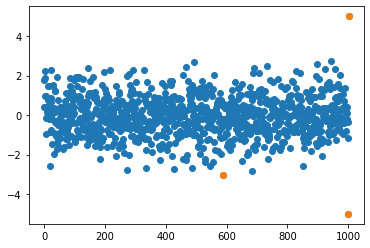

In [15]:
plt.scatter(range(len(data)), data)
plt.scatter(out_idx, data[out_idx]);

## ホテリング $T^{2}$ 法  


統計モデルに基づく異常検知技術(外れ値検知)で有名なものとして ホテリング $T^{2}$ 法があります。ホテリング $T^{2}$ 法ではデータの分布として**単一の正規分布にしたがっていると仮定のもと**で、異常度と閾値を定義します。この手法が有効に適用されるには、

1. データが単一の正規分布から発生している
2. データ中に異常な値を含まないか、含んでいたとしてもごくわずか

という制約が存在しますが、製造業などの単一の精度が求められる場面で多くの実績があります。


### データの準備

それでは、扱うデータを準備します。今回は、NumPy を使ってデータを作成します。  

NumPy では乱数を生成する際に便利な関数を用意してくれています。
正規分布に従うデータを生成したいので、 `np.random.normal` を使用します。関数の内部にランダムな要素を含む場合は、必ず実行前に乱数のシードの固定 `np.random.seed` を忘れないようにしておきましょう。

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# シードの固定
np.random.seed(0)

# 平均０, 標準偏差1, サンプル数1000の正規分布に従うデータも生成
x1 = np.random.normal(0, 1, 1000)
# 平均０, 標準偏差0.3, サンプル数1000の正規分布に従い, x1と相関をもつデータを生成
x2 = x1 + np.random.normal(0, 0.3, 1000)
# 異常データ
anomaly = np.array([[-4, -5], [-1.5, 2], [2.5, -2.5]])

x = np.stack([x1, x2], axis=1)
x_new = np.concatenate([x, anomaly], axis=0)

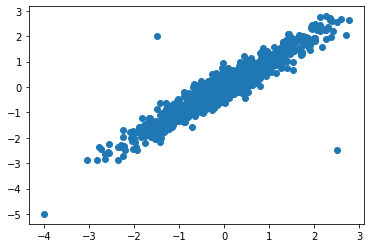

In [20]:
plt.scatter(x_new[:, 0], x_new[:, 1]);

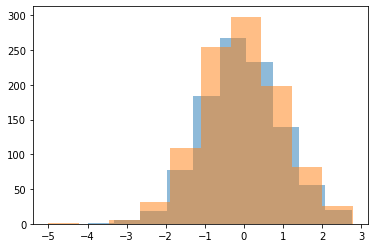

In [26]:
# histplot: ヒストグラム表示
plt.hist(x_new[:, 0], alpha = 0.5);
plt.hist(x_new[:, 1], alpha = 0.5);

### 異常度を定義

異常度 $a(X)$ を定義し、そこから人間側で設定した閾値によって異常を検知する必要があります。ホテリング$T^2$ 法では異常度にマハラノビス距離を使用することで、各特徴量の分散を考慮しながら距離を算出することができます。

$$
xa(X) = (X-\mu)^{T} \sum^{-1} (X-\mu)
$$  

$X$ は特徴ベクトル、$\mu$ は平均値ベクトル、$\sigma$ は共分散行列を示しています。

In [27]:
# 平均値
mean = np.mean(x_new, axis=0)

# 共分散行列
cov = np.cov(x_new.T)

NumPyでは、`np.linalg.pinv()` を使用することで逆行列を求めることができます。

また、SciPy では `distance.mahalanobis` メソッドが準備されており、引数に、(データ, 平均値ベクトル、逆共分散行列) を指定することで算出することができます。

まずは １ つのデータに対して異常度を算出してみましょう。

In [28]:
from scipy.spatial import distance
score = distance.mahalanobis(x_new[0], mean, np.linalg.pinv(cov))
score

1.9095518478691904

In [29]:
# 全体の異常度: a(x)
anomaly_scores = [distance.mahalanobis(x, mean, np.linalg.pinv(cov)) for x in x_new]
anomaly_scores[:10]

[1.9095518478691904,
 0.9103745962471754,
 1.0715290490218012,
 2.3051509686927014,
 1.9451138041397917,
 0.9370093642958925,
 1.1297688822655307,
 1.5771697876049209,
 0.07484224481875931,
 0.5143295952288854]

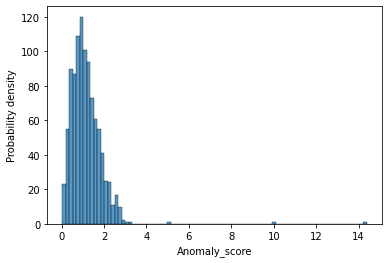

In [32]:
plt.xlabel('Anomaly_score')
plt.ylabel('Probability density')
sns.histplot(anomaly_scores);


### 閾値の決定

上記の異常度のグラフの右側何 % を異常値にするのかを手動で決めます。

より多くのデータを異常と判断させたければ異常発生の確率値を高くし、より多くの正常なデータを残しておきたいのであれば確率値を低くします。この異常なデータを排除することと正常なデータを残すことの間にはトレードオフの関係があり、どのように確率値を設定するかの判断は難しいですが、0.05 や 0.01 などの値がよく使用されます。

確率値を設定し、データ量が十分ある状態であれば、近似的に χ（カイ）二乗検定を用いて閾値を設定することができます。これは、ホテリング法の理論上、異常度が自由度が次元数でスケール因子 1 の χ（カイ）二乗検定に従うと数学的に証明できるためです 。具体的な証明などは省きますが、他の検定方法ではなく、χ（カイ）二乗検定を用いるのはこのためです。

それに対して「検定を行う」とは例えば確率値として 0.05 を指定した際に観測値に対して 正常時には 0.05 パーセント未満でしか起こらないくらい稀な値だから、正常でないだろう と意味付けをする行為のことを指します。

実装をする分には、確率値さえ設定すれば SciPy モジュールが閾値を設定してくれます。

※ χ（カイ）二乗分布について、詳しくは こちら  

今回は 2 次元であり、2 次元正規分布で χ（カイ）二乗分布が構成されているので、自由度 (dim) は 2 となります。異常発生の確率値は 0.1 としてみます。





In [33]:
from scipy import stats as st

# 確率値: f1, データの次元数: dim
f1 = 0.1
dim = 2

# 確率値、次元数から閾値を計算
threshold = st.chi2.ppf(1 - f1, dim)
threshold

4.605170185988092

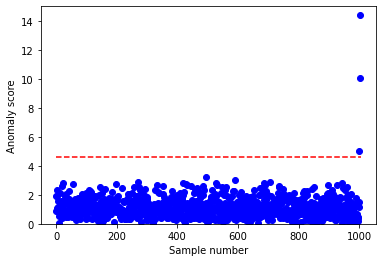

In [34]:
# 結果の描画
plt.plot(range(0, 1003), anomaly_scores, 'o', color = 'b')
plt.plot([0,1004],[threshold, threshold], color = 'r', ls = 'dashed')
plt.xlabel('Sample number')
plt.ylabel('Anomaly score')
plt.ylim([0,15])
plt.show()